# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential,load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras_hist_graph import plot_history

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [3]:
train_dir = 'dogs_224/train/'
validation_dir = 'dogs_224/validation/'
test_dir = 'dogs_224/test/'

STD_SIZE = (224, 224)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']


In [5]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  236
Number of train classes:  2
Number of train samples per class: 118 

Number of validation samples:  50
Number of validation classes:  2
Number of validation samples per class: 25 

Number of test samples:  51
Number of test classes:  2
Number of test samples per class: 26 

Files for train subset for 2 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

# Model

In [6]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [7]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 512))
test_features = np.reshape(test_features, (-1, 7 * 7 * 512))

In [8]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 236 samples, validate on 50 samples
Epoch 1/1000
 - 0s - loss: 0.7228 - acc: 0.5847 - val_loss: 0.5743 - val_acc: 0.6200

Epoch 00001: val_loss improved from inf to 0.57430, saving model to tl_freeze_conv_base_2_breeds
Epoch 2/1000
 - 0s - loss: 0.5577 - acc: 0.7076 - val_loss: 0.4469 - val_acc: 0.8200

Epoch 00002: val_loss improved from 0.57430 to 0.44688, saving model to tl_freeze_conv_base_2_breeds
Epoch 3/1000
 - 0s - loss: 0.4739 - acc: 0.7881 - val_loss: 0.3877 - val_acc: 0.9000

Epoch 00003: val_loss improved from 0.44688 to 0.38774, saving model to tl_freeze_conv_base_2_breeds
Epoch 4/1000
 - 0s - loss: 0.3882 - acc: 0.8390 - val_loss: 0.3346 - val_acc: 0.9200

Epoch 00004: val_loss improved from 0.38774 to 0.33456, saving model to tl_freeze_conv_base_2_breeds
Epoch 5/1000
 - 0s - loss: 0.3056 - acc: 0.9025 - val_loss: 0.3060 - val_acc: 0.9600

Epoch 00005: val_loss improved from 0.33456 to 0.30603, saving model to tl_freeze_conv_base_2_breeds
Epoch 6/1000
 - 0s - los

## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 0s 373us/step


[0.14192929677665234, 0.9411764740943909]

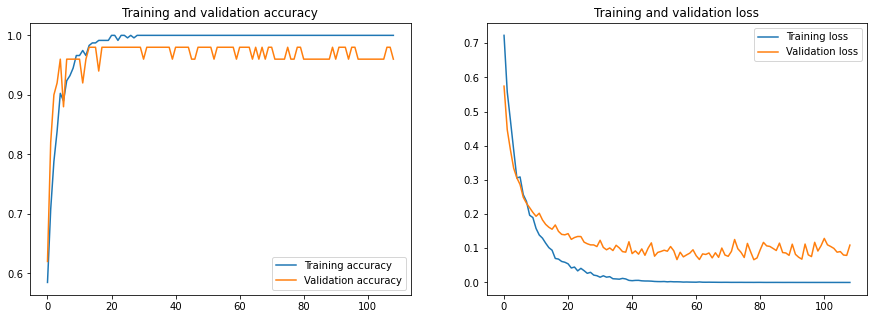

In [10]:
plot_accuracy_and_loss(history)

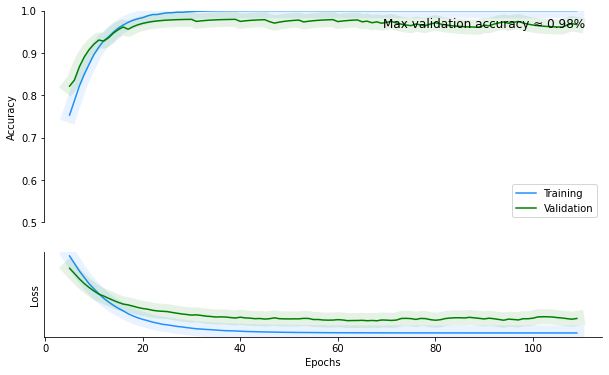

In [11]:
plot_history(history,xkcd=False)

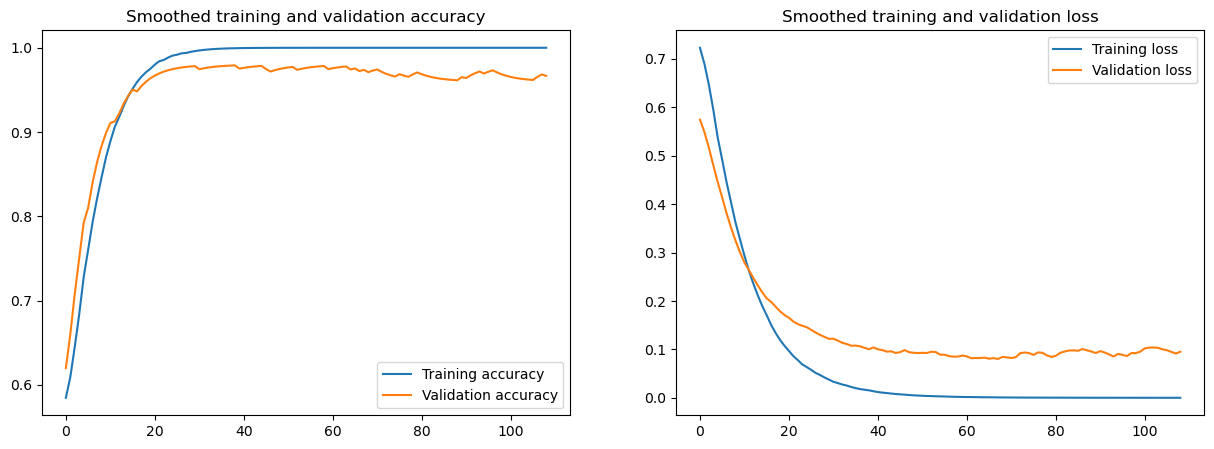

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [13]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


In [14]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  412
Number of train classes:  3
Number of train samples per class: 137 

Number of validation samples:  88
Number of validation classes:  3
Number of validation samples per class: 29 

Number of test samples:  89
Number of test classes:  3
Number of test samples per class: 30 

Files for train subset for 3 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\n0

## Model

In [15]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 512))
test_features = np.reshape(test_features, (-1, 7 * 7 * 512))

In [18]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 412 samples, validate on 88 samples
Epoch 1/1000
 - 0s - loss: 1.1678 - acc: 0.4442 - val_loss: 0.8468 - val_acc: 0.6932

Epoch 00001: val_loss improved from inf to 0.84676, saving model to tl_freeze_conv_base_3_breeds
Epoch 2/1000
 - 0s - loss: 0.9755 - acc: 0.5316 - val_loss: 0.7092 - val_acc: 0.7955

Epoch 00002: val_loss improved from 0.84676 to 0.70920, saving model to tl_freeze_conv_base_3_breeds
Epoch 3/1000
 - 0s - loss: 0.8247 - acc: 0.6214 - val_loss: 0.6248 - val_acc: 0.7955

Epoch 00003: val_loss improved from 0.70920 to 0.62483, saving model to tl_freeze_conv_base_3_breeds
Epoch 4/1000
 - 0s - loss: 0.6746 - acc: 0.7063 - val_loss: 0.5566 - val_acc: 0.8750

Epoch 00004: val_loss improved from 0.62483 to 0.55662, saving model to tl_freeze_conv_base_3_breeds
Epoch 5/1000
 - 0s - loss: 0.5276 - acc: 0.8131 - val_loss: 0.5155 - val_acc: 0.8636

Epoch 00005: val_loss improved from 0.55662 to 0.51552, saving model to tl_freeze_conv_base_3_breeds
Epoch 6/1000
 - 0s - los

## Results

In [19]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 0s 303us/step


[0.23460664365733608, 0.9213483333587646]

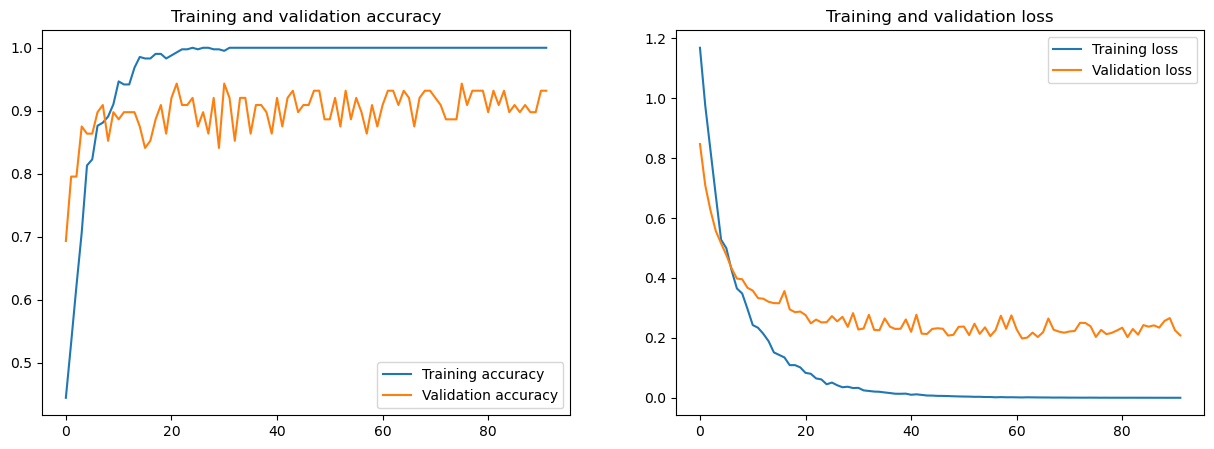

In [20]:
plot_accuracy_and_loss(history)

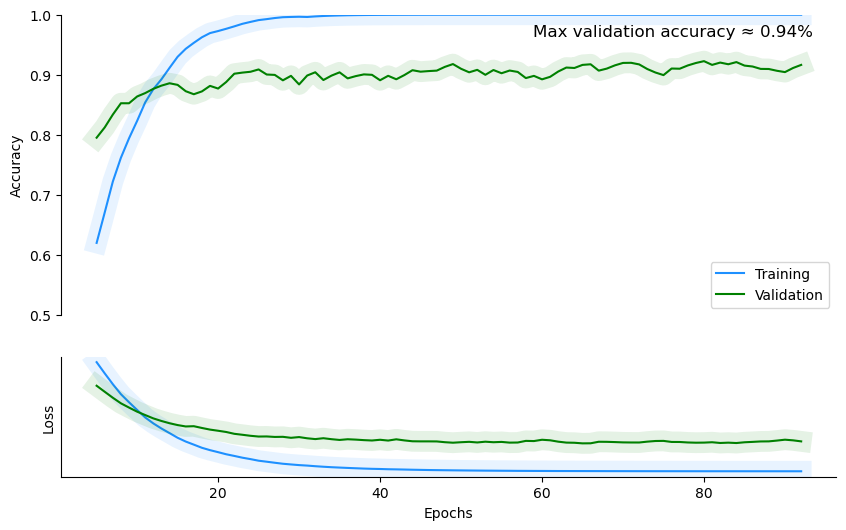

In [21]:
plot_history(history,xkcd=False)

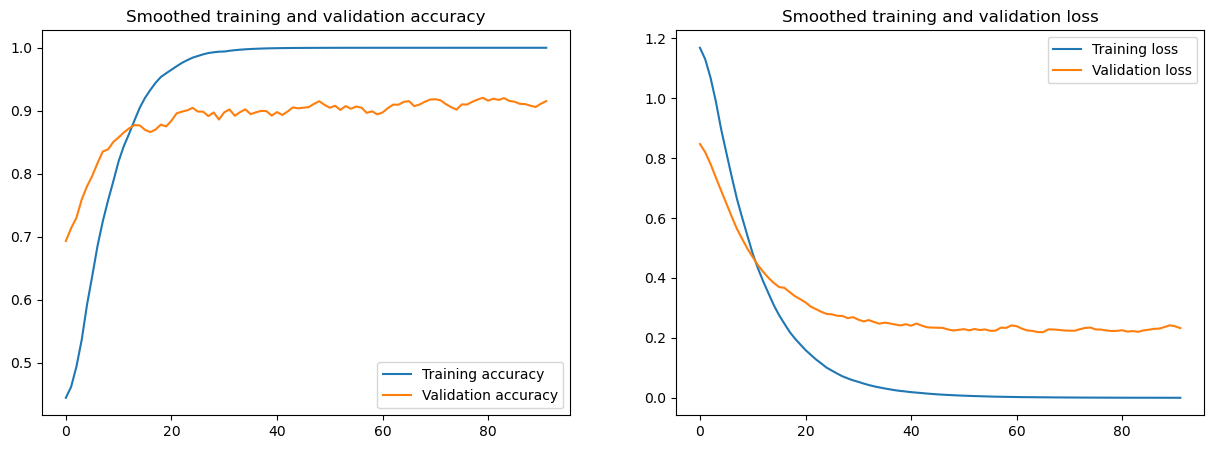

In [22]:
plot_smoothed_acc_and_loss(history, 0.8)

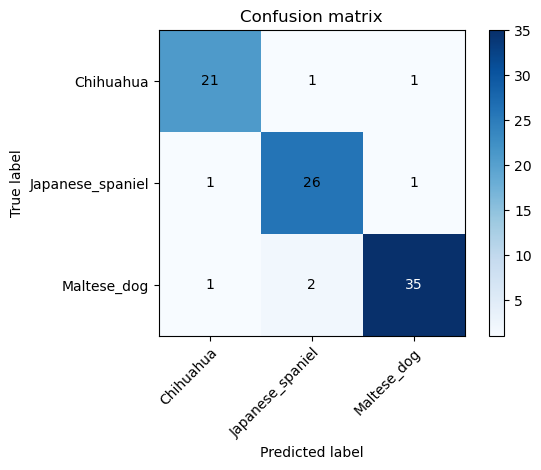

In [23]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [24]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']


In [25]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  666
Number of train classes:  5
Number of train samples per class: 133 

Number of validation samples:  143
Number of validation classes:  5
Number of validation samples per class: 29 

Number of test samples:  143
Number of test classes:  5
Number of test samples per class: 29 

Files for train subset for 5 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\

## Model

In [26]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [27]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 512))
test_features = np.reshape(test_features, (-1, 7 * 7 * 512))

In [29]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 666 samples, validate on 143 samples
Epoch 1/1000
 - 1s - loss: 1.6976 - acc: 0.2628 - val_loss: 1.4283 - val_acc: 0.4196

Epoch 00001: val_loss improved from inf to 1.42831, saving model to tl_freeze_conv_base_5_breeds
Epoch 2/1000
 - 0s - loss: 1.4791 - acc: 0.3754 - val_loss: 1.3266 - val_acc: 0.4825

Epoch 00002: val_loss improved from 1.42831 to 1.32655, saving model to tl_freeze_conv_base_5_breeds
Epoch 3/1000
 - 0s - loss: 1.3348 - acc: 0.4459 - val_loss: 1.2869 - val_acc: 0.4406

Epoch 00003: val_loss improved from 1.32655 to 1.28691, saving model to tl_freeze_conv_base_5_breeds
Epoch 4/1000
 - 0s - loss: 1.2030 - acc: 0.5315 - val_loss: 1.2090 - val_acc: 0.5594

Epoch 00004: val_loss improved from 1.28691 to 1.20904, saving model to tl_freeze_conv_base_5_breeds
Epoch 5/1000
 - 0s - loss: 1.0746 - acc: 0.5826 - val_loss: 1.1639 - val_acc: 0.5385

Epoch 00005: val_loss improved from 1.20904 to 1.16394, saving model to tl_freeze_conv_base_5_breeds
Epoch 6/1000
 - 0s - lo

## Results

In [30]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 0s 456us/step


[0.8287622211696385, 0.6573426723480225]

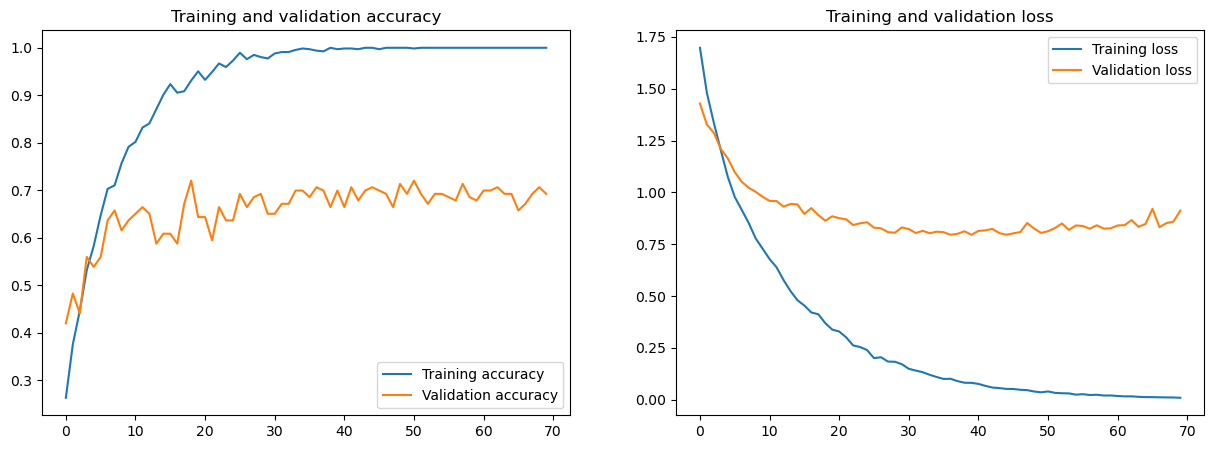

In [31]:
plot_accuracy_and_loss(history)

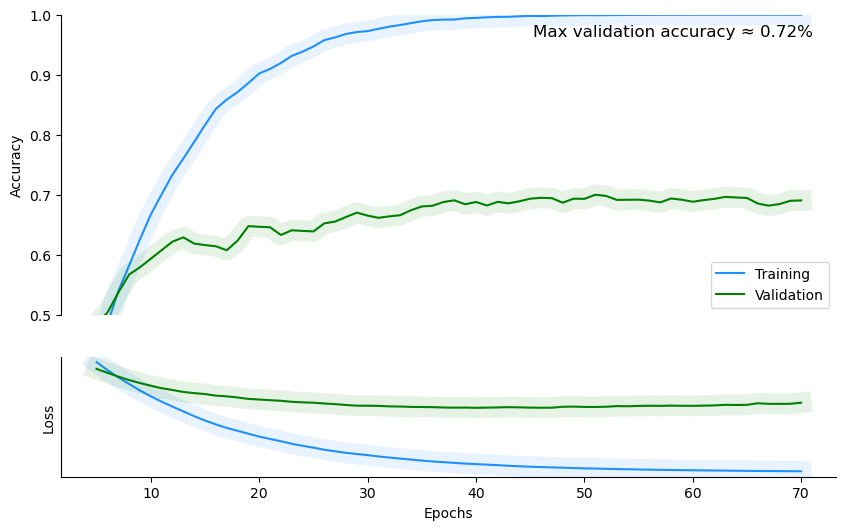

In [32]:
plot_history(history,xkcd=False)

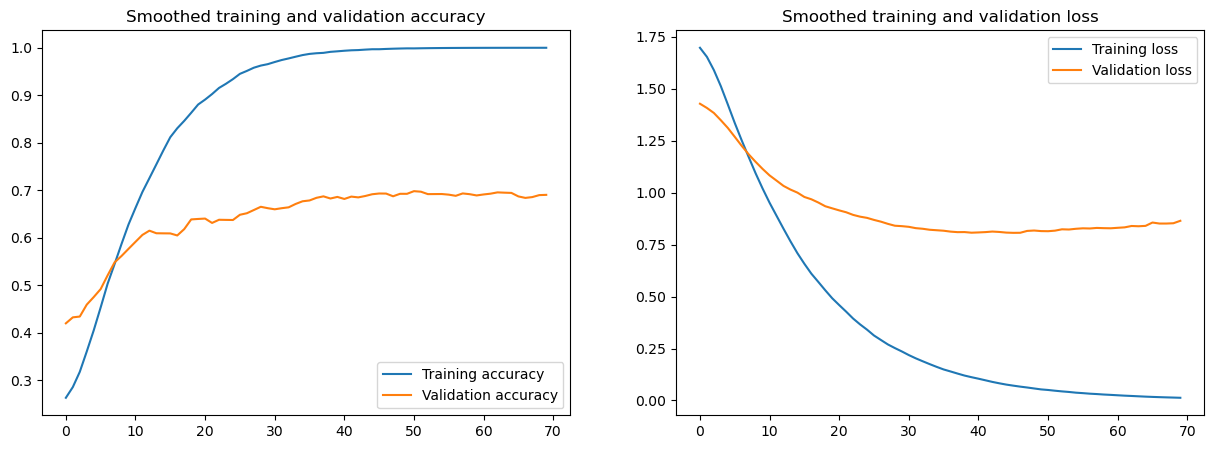

In [33]:
plot_smoothed_acc_and_loss(history, 0.8)

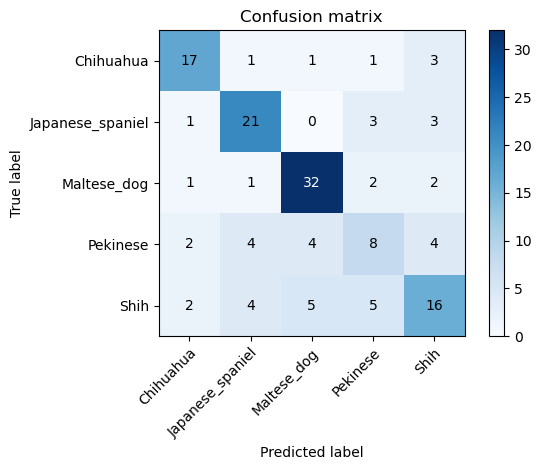

In [34]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [35]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

In [36]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  7072
Number of train classes:  60
Number of train samples per class: 118 

Number of validation samples:  1527
Number of validation classes:  60
Number of validation samples per class: 25 

Number of test samples:  1512
Number of test classes:  60
Number of test samples per class: 25 

Files for train subset for 60 classes 
 ['affenpinscher\\n02110627_10147.jpg', 'affenpinscher\\n02110627_10185.jpg', 'affenpinscher\\n02110627_10225.jpg', 'affenpinscher\\n02110627_10437.jpg', 'affenpinscher\\n02110627_10439.jpg', 'affenpinscher\\n02110627_10447.jpg', 'affenpinscher\\n02110627_10680.jpg', 'affenpinscher\\n02110627_10787.jpg', 'affenpinscher\\n02110627_10848.jpg', 'affenpinscher\\n02110627_10859.jpg', 'affenpinscher\\n02110627_10986.jpg', 'affenpinscher\\n02110627_11211.jpg', 'affenpinscher\\n02110627_11262.jpg', 'affenpinscher\\n02110627_11263.jpg', 'affenpinscher\\n02110627_11279.jpg', 'affenpinscher\\n02110627_11283.jpg', 'affenpinscher\\n02110627_11345.jpg', 

## Model

In [37]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [38]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [39]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 512))
test_features = np.reshape(test_features, (-1, 7 * 7 * 512))

In [40]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 7072 samples, validate on 1527 samples
Epoch 1/1000
 - 7s - loss: 4.0758 - acc: 0.0355 - val_loss: 3.8111 - val_acc: 0.0956

Epoch 00001: val_loss improved from inf to 3.81107, saving model to tl_freeze_conv_base_60_breeds
Epoch 2/1000
 - 7s - loss: 3.6811 - acc: 0.1080 - val_loss: 3.5200 - val_acc: 0.1473

Epoch 00002: val_loss improved from 3.81107 to 3.51996, saving model to tl_freeze_conv_base_60_breeds
Epoch 3/1000
 - 7s - loss: 3.3235 - acc: 0.1715 - val_loss: 3.2252 - val_acc: 0.2187

Epoch 00003: val_loss improved from 3.51996 to 3.22521, saving model to tl_freeze_conv_base_60_breeds
Epoch 4/1000
 - 7s - loss: 2.9734 - acc: 0.2424 - val_loss: 3.0151 - val_acc: 0.2508

Epoch 00004: val_loss improved from 3.22521 to 3.01511, saving model to tl_freeze_conv_base_60_breeds
Epoch 5/1000
 - 7s - loss: 2.6409 - acc: 0.3187 - val_loss: 2.8308 - val_acc: 0.2816

Epoch 00005: val_loss improved from 3.01511 to 2.83076, saving model to tl_freeze_conv_base_60_breeds
Epoch 6/1000
 - 

## Results

In [41]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 1s 615us/step


[2.256897102588068, 0.40145501494407654]

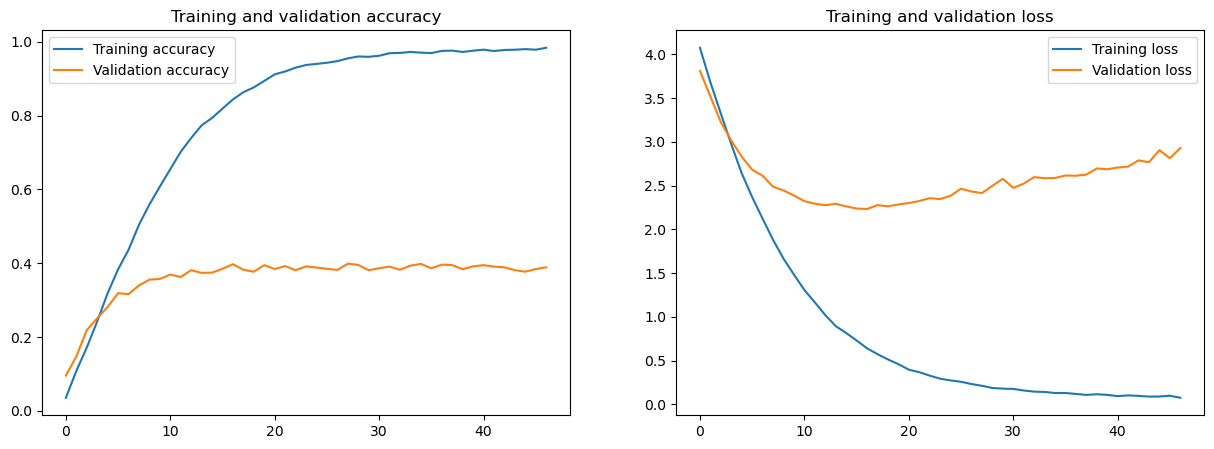

In [42]:
plot_accuracy_and_loss(history)

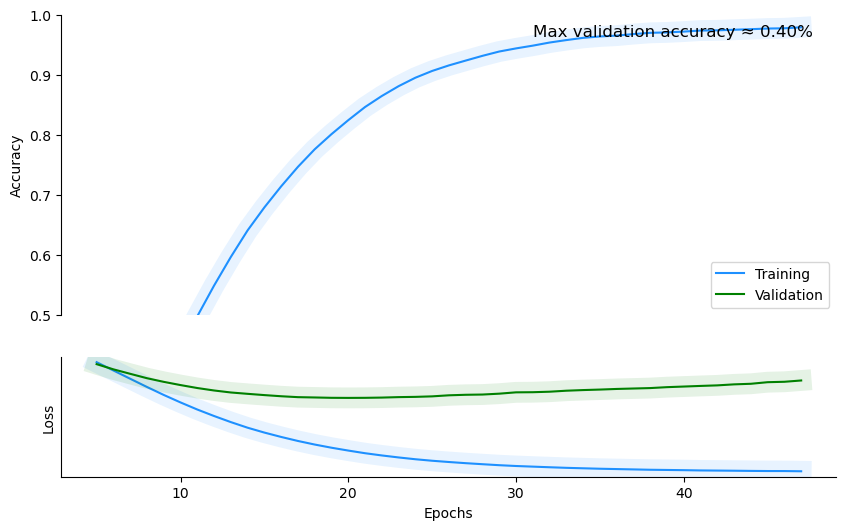

In [43]:
plot_history(history,xkcd=False)

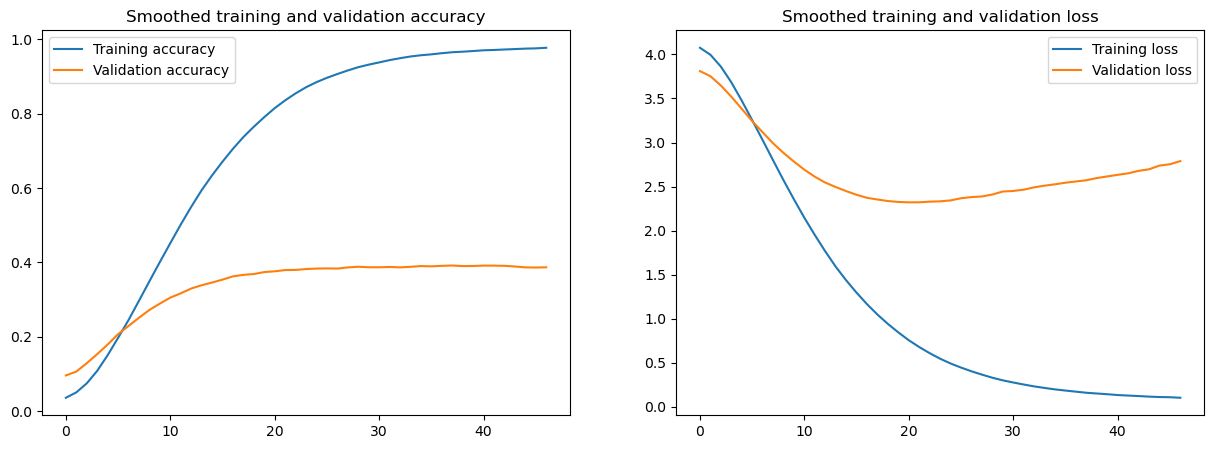

In [44]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds

## Data preparation

In [45]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

In [46]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  14397
Number of train classes:  120
Number of train samples per class: 120 

Number of validation samples:  3099
Number of validation classes:  120
Number of validation samples per class: 26 

Number of test samples:  3084
Number of test classes:  120
Number of test samples per class: 26 

Files for train subset for 120 classes 
 ['Afghan_hound\\n02088094_1003.jpg', 'Afghan_hound\\n02088094_1007.jpg', 'Afghan_hound\\n02088094_1023.jpg', 'Afghan_hound\\n02088094_10263.jpg', 'Afghan_hound\\n02088094_10715.jpg', 'Afghan_hound\\n02088094_10822.jpg', 'Afghan_hound\\n02088094_10832.jpg', 'Afghan_hound\\n02088094_10982.jpg', 'Afghan_hound\\n02088094_11006.jpg', 'Afghan_hound\\n02088094_11172.jpg', 'Afghan_hound\\n02088094_11182.jpg', 'Afghan_hound\\n02088094_1126.jpg', 'Afghan_hound\\n02088094_1128.jpg', 'Afghan_hound\\n02088094_11432.jpg', 'Afghan_hound\\n02088094_1145.jpg', 'Afghan_hound\\n02088094_115.jpg', 'Afghan_hound\\n02088094_1150.jpg', 'Afghan_hound\\n02088

# Model

In [47]:
conv_base = VGG16(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [48]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [49]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 512), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 512))
test_features = np.reshape(test_features, (-1, 7 * 7 * 512))

In [50]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 14397 samples, validate on 3099 samples
Epoch 1/1000
 - 10s - loss: 4.8166 - acc: 0.0138 - val_loss: 4.7066 - val_acc: 0.0284

Epoch 00001: val_loss improved from inf to 4.70663, saving model to tl_freeze_conv_base_120_breeds
Epoch 2/1000
 - 9s - loss: 4.6469 - acc: 0.0306 - val_loss: 4.5701 - val_acc: 0.0565

Epoch 00002: val_loss improved from 4.70663 to 4.57009, saving model to tl_freeze_conv_base_120_breeds
Epoch 3/1000
 - 9s - loss: 4.4892 - acc: 0.0519 - val_loss: 4.4166 - val_acc: 0.0823

Epoch 00003: val_loss improved from 4.57009 to 4.41663, saving model to tl_freeze_conv_base_120_breeds
Epoch 4/1000
 - 9s - loss: 4.3104 - acc: 0.0831 - val_loss: 4.2701 - val_acc: 0.1081

Epoch 00004: val_loss improved from 4.41663 to 4.27007, saving model to tl_freeze_conv_base_120_breeds
Epoch 5/1000
 - 9s - loss: 4.1314 - acc: 0.1059 - val_loss: 4.1400 - val_acc: 0.1265

Epoch 00005: val_loss improved from 4.27007 to 4.14003, saving model to tl_freeze_conv_base_120_breeds
Epoch 6/1

## Results

In [51]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 1s 331us/step


[2.6650949707291005, 0.34403371810913086]

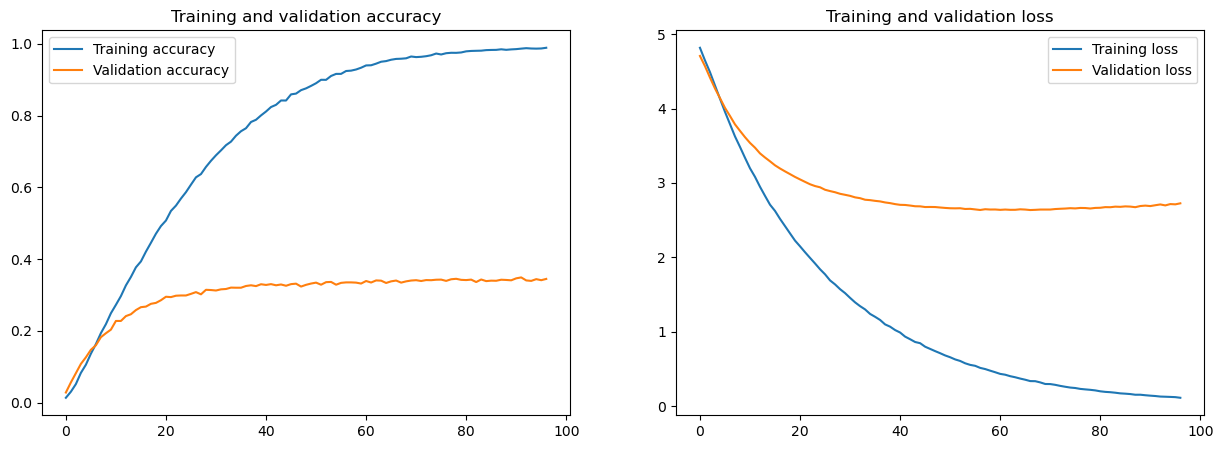

In [52]:
plot_accuracy_and_loss(history)

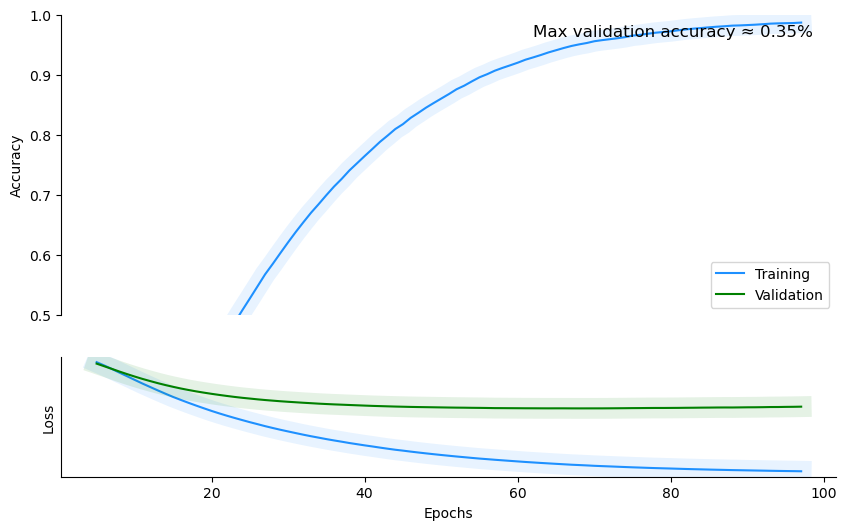

In [53]:
plot_history(history,xkcd=False)

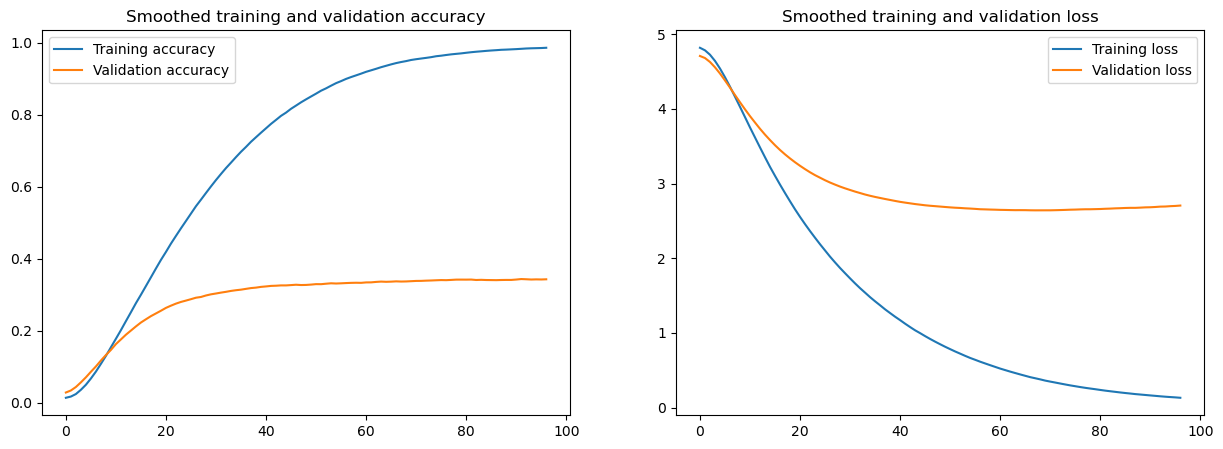

In [54]:
plot_smoothed_acc_and_loss(history, 0.8)